In [218]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import seaborn as sns
import zipfile, glob, json
import matplotlib.pyplot as plt
import statsmodels.api as sm
import forecastio
import datetime
import data_processing
from scipy.stats import scoreatpercentile
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_validation import cross_val_score, train_test_split
pd.options.display.max_columns = 500
pd.options.display.max_rows = 10000
%matplotlib inline

In [38]:
min_max_scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
imputer = preprocessing.Imputer()

In [30]:
df_noaa_import =  pd.read_pickle('../data/noaa/daily/df_noaa_daily_chicago.pkl')
df_cta_import = pd.read_csv('../data/cta/cta_daily.csv', parse_dates =['service_date'], 
                            index_col='service_date')
# df_flu_import = pd.read_csv('../data/flu/google_flu_trends.txt', 
#                             parse_dates=['Date'], usecols=['Date','San Francisco, CA'], index_col='Date')

## Feature engineering NOAA daily weather data 

In [409]:
df_noaa_daily = df_noaa_import.copy()

In [410]:
numeric_cols = ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 
                'Cool', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 
                'AvgSpeed', 'Max5Speed', 'Max5Dir', 'Max2Speed', 'Max2Dir']

for col in numeric_cols:
    df_noaa_daily[col].replace('  T', 0, inplace=True)
    df_noaa_daily[col].replace(' ', 0, inplace=True)
    df_noaa_daily[col] = pd.to_numeric(df_noaa_daily[col], errors='coerce')
#     df_noaa_daily[df_noaa_daily[col].isnull()] = df_noaa_daily[col].mean()

In [411]:
# df_noaa_daily.drop(['WBAN', 'YearMonthDay', 'WetBulb', 'Max5Dir', 'Max2Dir'], axis=1, inplace=True)

In [412]:
df_noaa_daily.drop(['WBAN', 'YearMonthDay', 'ResultDir', 
                    'Max5Dir', 'Max2Dir', 'Cool', 'Heat', 'WetBulb', 'Max5Speed', 'Max2Speed'], axis=1, inplace=True)

In [413]:
df = df_noaa_daily.copy()

In [414]:
df['month'] = pd.DatetimeIndex(df.index).month
df['dayofweek'] = pd.DatetimeIndex(df.index).weekday
df['dayofyear'] = pd.DatetimeIndex(df.index).dayofyear
df['weekofyear'] = pd.DatetimeIndex(df.index).weekofyear

In [415]:
cal = calendar()

In [416]:
holidays = cal.holidays(start=df.index.min(), end=df.index.max())
holidays

DatetimeIndex(['2011-01-17', '2011-02-21', '2011-05-30', '2011-07-04',
               '2011-09-05', '2011-10-10', '2011-11-11', '2011-11-24',
               '2011-12-26', '2012-01-02', '2012-01-16', '2012-02-20',
               '2012-05-28', '2012-07-04', '2012-09-03', '2012-10-08',
               '2012-11-12', '2012-11-22', '2012-12-25', '2013-01-01',
               '2013-01-21', '2013-02-18', '2013-05-27', '2013-07-04',
               '2013-09-02', '2013-10-14', '2013-11-11', '2013-11-28',
               '2013-12-25', '2014-01-01', '2014-01-20', '2014-02-17',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13',
               '2014-11-11', '2014-11-27', '2014-12-25', '2015-01-01',
               '2015-01-19', '2015-02-16', '2015-05-25', '2015-07-03',
               '2015-09-07', '2015-10-12', '2015-11-11', '2015-11-26',
               '2015-12-25'],
              dtype='datetime64[ns]', freq=None)

In [417]:
df['holiday'] = 0
df.loc[df.index.isin(holidays), 'holiday'] = 1

In [418]:
# c = ['Tmin','AvgSpeed', 'DewPoint']
# d = ['7', '14', '21', '28']

# for col in c:
#     for day in d:
#         df[col+day] = pd.rolling_mean(df[col], int(day))

In [419]:
# c = ['PrecipTotal']
# d = ['3', '7', '14', '21']

# for col in c:
#     for day in d:
#         df[col+day] = pd.rolling_sum(df[col], int(day))

In [420]:
c = ['Tmin','AvgSpeed', 'DewPoint', 'PrecipTotal']
d = ['-1', '-2', '-7']

for col in c:
    for day in d:
        df[col+day] = df[col].shift(int(day))

In [421]:
# c = ['Tmax', 'Tmin','AvgSpeed', 'DewPoint', 'PrecipTotal']
# d = ['-1', '-2', '-3', '-7']

# for col in c:
#     for day in d:
#         df[col+day] = df[col].shift(int(day))

In [422]:
df.head(20)

,Tmax,Tmin,Tavg,DewPoint,PrecipTotal,ResultSpeed,AvgSpeed,month,dayofweek,dayofyear,weekofyear,holiday,Tmin-1,Tmin-2,Tmin-7,AvgSpeed-1,AvgSpeed-2,AvgSpeed-7,DewPoint-1,DewPoint-2,DewPoint-7,PrecipTotal-1,PrecipTotal-2,PrecipTotal-7
date,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01,46,15,31,11,0.00,19.4,18.7,1,5,1,52,0,13,22,10,11.4,7.2,12.6,8,17,5,0.00,0.00,0.00
2011-01-02,25,13,19,8,0.00,10.6,11.4,1,6,2,52,0,22,14,11,7.2,11.0,3.1,17,12,9,0.00,0.00,0.00
2011-01-03,36,22,29,17,0.00,6.9,7.2,1,0,3,1,0,14,11,19,11.0,7.2,7.8,12,13,13,0.00,0.00,0.00
2011-01-04,32,14,23,12,0.00,10.9,11.0,1,1,4,1,0,11,19,23,7.2,11.5,9.4,13,12,19,0.00,0.00,0.09
2011-01-05,32,11,22,13,0.00,5.5,7.2,1,2,5,1,0,19,13,22,11.5,10.6,12.5,12,8,16,0.00,0.00,0.00
2011-01-06,30,19,25,12,0.00,11.4,11.5,1,3,6,1,0,13,10,16,10.6,12.6,7.9,8,5,14,0.00,0.00,0.00
2011-01-07,23,13,18,8,0.00,10.2,10.6,1,4,7,1,0,10,11,17,12.6,3.1,5.6,5,9,14,0.00,0.00,0.00
2011-01-08,24,10,17,5,0.00,12.4,12.6,1,5,8,1,0,11,19,18,3.1,7.8,11.6,9,13,13,0.00,0.00,0.00
2011-01-09,31,11,21,9,0.00,2.2,3.1,1,6,9,1,0,19,23,10,7.8,9.4,4.9,13,19,11,0.00,0.09,0.00


In [423]:
df.columns

Index([u'Tmax', u'Tmin', u'Tavg', u'DewPoint', u'PrecipTotal', u'ResultSpeed',
       u'AvgSpeed', u'month', u'dayofweek', u'dayofyear', u'weekofyear',
       u'holiday', u'Tmin-1', u'Tmin-2', u'Tmin-7', u'AvgSpeed-1',
       u'AvgSpeed-2', u'AvgSpeed-7', u'DewPoint-1', u'DewPoint-2',
       u'DewPoint-7', u'PrecipTotal-1', u'PrecipTotal-2', u'PrecipTotal-7'],
      dtype='object')

In [424]:
df[df.columns] = imputer.fit_transform(df[df.columns])

In [425]:
df.head()

,Tmax,Tmin,Tavg,DewPoint,PrecipTotal,ResultSpeed,AvgSpeed,month,dayofweek,dayofyear,weekofyear,holiday,Tmin-1,Tmin-2,Tmin-7,AvgSpeed-1,AvgSpeed-2,AvgSpeed-7,DewPoint-1,DewPoint-2,DewPoint-7,PrecipTotal-1,PrecipTotal-2,PrecipTotal-7
date,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01,46,15,31,11,0,19.4,18.7,1,5,1,52,0,13,22,10,11.4,7.2,12.6,8,17,5,0,0,0.00
2011-01-02,25,13,19,8,0,10.6,11.4,1,6,2,52,0,22,14,11,7.2,11.0,3.1,17,12,9,0,0,0.00
2011-01-03,36,22,29,17,0,6.9,7.2,1,0,3,1,0,14,11,19,11.0,7.2,7.8,12,13,13,0,0,0.00
2011-01-04,32,14,23,12,0,10.9,11.0,1,1,4,1,0,11,19,23,7.2,11.5,9.4,13,12,19,0,0,0.09
2011-01-05,32,11,22,13,0,5.5,7.2,1,2,5,1,0,19,13,22,11.5,10.6,12.5,12,8,16,0,0,0.00


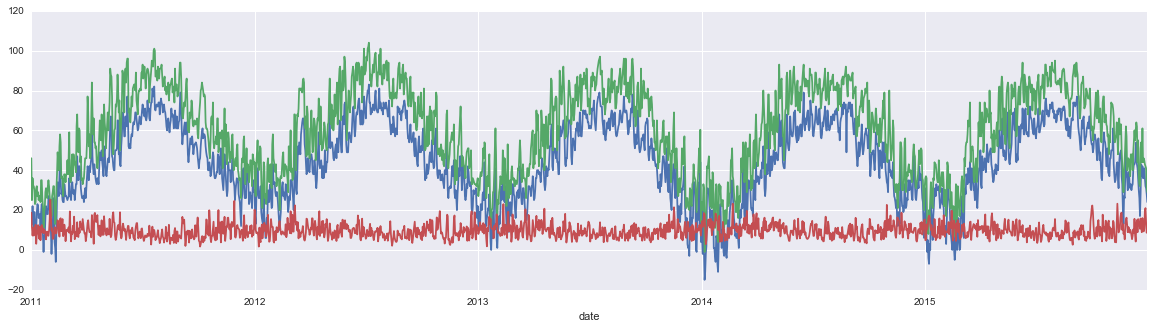

In [426]:
df.resample('D', how='sum')['Tmin'].plot(figsize=(20,5))
df.resample('D', how='sum')['Tmax'].plot(figsize=(20,5))
df.resample('D', how='sum')['AvgSpeed'].plot(figsize=(20,5))

## Flu data

In [427]:
# df_flu_import.info()

In [428]:
# df_flu_import = df_flu_import.resample('1D', fill_method='ffill')

In [429]:
# df_flu = df_flu_import['20110101':'20150809'].copy()

In [430]:
# imputer = preprocessing.Imputer()
# df_flu[df_flu.columns] = imputer.fit_transform(df_flu[df_flu.columns])

In [431]:
# df_flu.columns = ['flu']

In [432]:
# df_flu['flu_scaled'] = min_max_scaler.fit_transform(df_flu['San Francisco, CA'].reshape(-1, 1))

In [433]:
# c = ['flu_scaled']
# d = ['7', '14', '21', '28']

# for col in c:
#     for day in d:
#         df_flu[col+day] = pd.rolling_sum(df_flu[col], int(day))

In [434]:
# imputer = preprocessing.Imputer()
# df_flu[df_flu.columns] = imputer.fit_transform(df_flu[df_flu.columns])

In [435]:
# df_flu.shape

In [436]:
# df_flu.head()

In [437]:
# df = df.merge(df_flu, how='outer', left_index=True, right_index=True)

In [438]:
# df.head()

## Get Forecastio data

In [8]:
# forecast_api = '/Users/Engel/api/keys/forecastio-api.json'

In [9]:
# with open(forecast_api) as f:
#     data = json.load(f)
#     api_key = data['api_key']

In [10]:
# #Sears tower
# lat = 41.8789
# lng = -87.6359

In [11]:
# from datetime import timedelta, date

# def daterange(start_date, end_date):
#     for n in range(int ((end_date - start_date).days)):
#         yield start_date + timedelta(n)

# df_list = []
        
# start_date = datetime.datetime(2013, 6, 30, 7, 0, 0)
# end_date = datetime.datetime(2016, 1, 1, 7, 0, 0)
# for single_date in daterange(start_date, end_date):
#     forecast = forecastio.load_forecast(api_key, lat, lng, time=single_date)
#     timestr = single_date.strftime("%Y%m%d-%H%M%S")
#     with open('../data/forecastio/chicago/' + timestr + '-forecastio-Chi.json', 'w') as outfile:
#         json.dump(forecast.json, outfile)
#     df_tempd = pd.DataFrame(forecast.json['daily']['data'])
#     df_list.append(df_tempd)   

# df_daily = pd.concat(df_list, ignore_index=True, axis=0)

In [16]:
# df_daily.columns = [x.lower() for x in df_daily.columns]

In [23]:
# df_daily = df_daily[['apparenttemperaturemax',
#  'apparenttemperaturemin', 'precipintensity',
#  'precipintensitymax',  'pressure', 'temperaturemax',
#  'temperaturemin', 'time', 'windspeed']]

In [24]:
# df_daily.to_pickle('../data/forecastio/chicago/forecastio_Chi_daily.pkl')

In [80]:
df_daily.head()

,apparenttemperaturemax,apparenttemperaturemin,precipintensity,precipintensitymax,pressure,temperaturemax,temperaturemin,time,windspeed
0,69.52,63.23,0.0000,0.0000,1011.59,69.52,63.23,1372568400,14.25
1,69.46,62.63,0.0000,0.0000,1016.65,69.46,62.63,1372654800,13.23
2,65.06,61.29,0.0000,0.0000,1017.97,65.06,61.29,1372741200,12.36
3,67.03,61.29,0.0022,0.0332,1017.42,67.03,61.29,1372827600,4.54
4,78.80,61.85,0.0000,0.0000,1018.33,78.80,61.85,1372914000,8.05


In [219]:
df_forecast = pd.read_pickle('../data/forecastio/chicago/forecastio_Chi_daily.pkl')

In [220]:
df = data_processing.clean_data(df_forecast)

In [221]:
df.head()

,apparenttemperaturemax,apparenttemperaturemin,pressure,temperaturemax,temperaturemin,windspeed,dayofweek,dayofyear,weekofyear,holiday,apparenttemperaturemax7,apparenttemperaturemin7,temperaturemax7,temperaturemin7,apparenttemperaturemax-3,apparenttemperaturemax-7,apparenttemperaturemin-3,apparenttemperaturemin-7,windspeed-3,windspeed-7
time,,,,,,,,,,,,,,,,,,,,
2013-06-30,69.52,63.23,1011.59,69.52,63.23,14.25,6,181,26,0,0,0,0,0,67.03,88.38,61.29,70.61,4.54,8.21
2013-07-01,69.46,62.63,1016.65,69.46,62.63,13.23,0,182,27,0,0,0,0,0,78.80,89.96,61.85,70.89,8.05,10.68
2013-07-02,65.06,61.29,1017.97,65.06,61.29,12.36,1,183,27,0,0,0,0,0,79.14,89.66,64.87,73.08,4.91,7.20
2013-07-03,67.03,61.29,1017.42,67.03,61.29,4.54,2,184,27,0,0,0,0,0,78.86,85.31,69.47,68.88,5.80,3.66
2013-07-04,78.80,61.85,1018.33,78.80,61.85,8.05,3,185,27,1,0,0,0,0,88.38,75.71,70.61,65.08,8.21,5.31


## Chicago CTA data

In [178]:
df_cta = df_cta_import['20110101':'20151231'].copy()

In [179]:
# df_cta = df_cta_import.copy()

In [180]:
df_cta.head()

,day_type,bus,rail_boardings,total_rides
service_date,,,,
2011-01-01,U,342872,239754,582626
2011-01-02,U,364165,225886,590051
2011-01-03,W,925770,581035,1506805
2011-01-04,W,946232,621057,1567289
2011-01-05,W,950712,624027,1574739


In [181]:
df_cta.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1888 entries, 2011-01-01 to 2015-12-31
Data columns (total 4 columns):
day_type          1888 non-null object
bus               1888 non-null float64
rail_boardings    1888 non-null float64
total_rides       1888 non-null float64
dtypes: float64(3), object(1)
memory usage: 73.8+ KB


In [182]:
df_cta.columns

Index([u'day_type', u'bus', u'rail_boardings', u'total_rides'], dtype='object')

In [183]:
df_cta.drop(['day_type'], axis=1, inplace=True)

In [184]:
# df_cta[df_cta.columns] = imputer.fit_transform(df_cta[df_cta.columns])

In [185]:
df_cta = df_cta.resample('1D', how={'total_rides': np.mean})

In [186]:
df_cta.head()

,total_rides
service_date,
2011-01-01,582626
2011-01-02,590051
2011-01-03,1506805
2011-01-04,1567289
2011-01-05,1574739


In [187]:
df_cta.shape

(1826, 1)

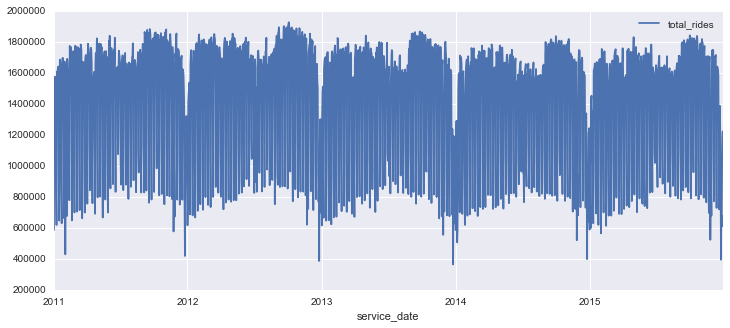

In [188]:
df_cta.plot(figsize=(12,5))

In [189]:
df_cta[df_cta.columns] = min_max_scaler.fit_transform(df_cta[df_cta.columns])

In [190]:
df_cta['dayofweek'] = pd.DatetimeIndex(df_cta.index).weekday

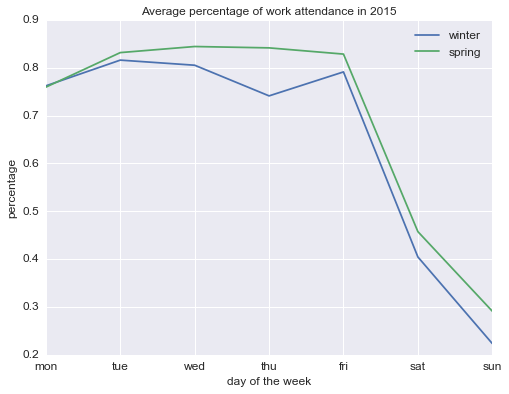

In [191]:
df_cta['20141001':'20150330'].groupby('dayofweek')['total_rides'].mean().plot(figsize=(8,6), 
                title='Average percentage of work attendance in 2015', fontsize = 12, label='winter')
df_cta['20150401':'20150930'].groupby('dayofweek')['total_rides'].mean().plot(figsize=(8,6), 
                title='Average percentage of work attendance in 2015', fontsize = 12, label='spring')
# df_cta['20150501':'20150730'].groupby('dayofweek')['total_rides'].mean().plot(figsize=(8,6), 
#                 title='Average percentage of work attendance in 2015', fontsize = 12, label='summer')
# df_cta['20150801':'20151030'].groupby('dayofweek')['total_rides'].mean().plot(figsize=(8,6), 
#                 title='MORNING BART EXITS / % WORK ATTENDANCE BY SEASON', fontsize = 12, label='fall', color ='orange')
# df_bart['20110101':'20111231'].groupby('dayofweek')['counts_normed'].mean().plot(figsize=(8,5), 
#                 title='Average percentage of work attendance in 2015', fontsize = 13, label='2011')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['mon','tue','wed','thu','fri','sat','sun'], fontsize=12)
plt.xlabel("day of the week", fontsize=12)
plt.ylabel('percentage', fontsize=12)
plt.legend(fontsize = 12)

In [192]:
df_cta.head()

,total_rides,dayofweek
service_date,,
2011-01-01,0.140432,5
2011-01-02,0.145181,6
2011-01-03,0.731575,0
2011-01-04,0.770263,1
2011-01-05,0.775029,2


In [193]:
df.head()

,pressure,temperaturemax,temperaturemin,windspeed,dayofweek,dayofyear,weekofyear,holiday,apparenttemperaturemax7,apparenttemperaturemax21,apparenttemperaturemin7,apparenttemperaturemin21,pressure7,pressure21,windspeed7,windspeed21,temperaturemax7,temperaturemax21,temperaturemin7,temperaturemin21,apparenttemperaturemax-3,apparenttemperaturemax-7,apparenttemperaturemin-3,apparenttemperaturemin-7,windspeed-3,windspeed-7
time,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-06-30,1011.59,69.52,63.23,14.25,6,181,26,0,0,0,0,0,0,0,0,0,0,0,0,0,67.03,88.38,61.29,70.61,4.54,8.21
2013-07-01,1016.65,69.46,62.63,13.23,0,182,27,0,0,0,0,0,0,0,0,0,0,0,0,0,78.80,89.96,61.85,70.89,8.05,10.68
2013-07-02,1017.97,65.06,61.29,12.36,1,183,27,0,0,0,0,0,0,0,0,0,0,0,0,0,79.14,89.66,64.87,73.08,4.91,7.20
2013-07-03,1017.42,67.03,61.29,4.54,2,184,27,0,0,0,0,0,0,0,0,0,0,0,0,0,78.86,85.31,69.47,68.88,5.80,3.66
2013-07-04,1018.33,78.80,61.85,8.05,3,185,27,1,0,0,0,0,0,0,0,0,0,0,0,0,88.38,75.71,70.61,65.08,8.21,5.31


## Split data into seasons

In [194]:
# df_cold = df.merge(df_bart, how='outer', left_index=True, right_index=True)

In [195]:
# df_cold = df_cold.loc[(df_cold['seasons'] == 1) | (df_cold['seasons'] == 3)]

In [196]:
# df_cold.head()

## Random Forest

In [222]:
df_train = df.copy()

In [223]:
# y = df_cta['20141101':'20150130'].total_rides.values
# X = df_train['20141101':'20150130'].values

In [224]:
y = df_cta['20130630':'20151231'].total_rides.values
X = df_train['20130630':'20151231'].values

In [225]:
# y = df_cta.total_rides.values
# X = df_train.values

In [226]:
rf = RandomForestRegressor(40, n_jobs=-1)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [227]:
feat_rank = np.argsort(rf.feature_importances_)[::-1]
feat_rank

array([ 6,  9,  7,  8,  1,  0,  4, 16, 19,  2,  5,  3, 14, 12, 10, 11, 17,
       15, 18, 13])

In [228]:
df.columns[feat_rank]

Index([               u'dayofweek',                  u'holiday',
                      u'dayofyear',               u'weekofyear',
         u'apparenttemperaturemin',   u'apparenttemperaturemax',
                 u'temperaturemin', u'apparenttemperaturemin-3',
                    u'windspeed-7',                 u'pressure',
                      u'windspeed',           u'temperaturemax',
       u'apparenttemperaturemax-3',          u'temperaturemax7',
        u'apparenttemperaturemax7',  u'apparenttemperaturemin7',
       u'apparenttemperaturemin-7', u'apparenttemperaturemax-7',
                    u'windspeed-3',          u'temperaturemin7'],
      dtype='object')

In [229]:
df_features = pd.DataFrame(rf.feature_importances_,df_train.columns, columns = ['feature_value'])
df_features.sort_values('feature_value', ascending=False)

,feature_value
dayofweek,0.738986
holiday,0.095067
dayofyear,0.068031
weekofyear,0.016047
apparenttemperaturemin,0.013100
apparenttemperaturemax,0.011124
temperaturemin,0.008186
apparenttemperaturemin-3,0.005478
windspeed-7,0.005409
pressure,0.005351


In [230]:
cross_val_score(rf, X, y, cv=5).mean()

0.92748875575793599

In [231]:
scores = np.zeros((feat_rank.shape[0],2))
for i in range(1,feat_rank.shape[0]+1):
    features = [df.columns[feat_rank][x] for x in range(i)]
    scores[i-1:] = (i,(cross_val_score(rf, X, y, cv=5)).mean())
scores

array([[  1.        ,   0.92582359],
       [  2.        ,   0.92853707],
       [  3.        ,   0.92776824],
       [  4.        ,   0.93015443],
       [  5.        ,   0.9314347 ],
       [  6.        ,   0.92749143],
       [  7.        ,   0.92662214],
       [  8.        ,   0.92692717],
       [  9.        ,   0.93064436],
       [ 10.        ,   0.92447782],
       [ 11.        ,   0.92712333],
       [ 12.        ,   0.92785163],
       [ 13.        ,   0.92877531],
       [ 14.        ,   0.92941357],
       [ 15.        ,   0.92692029],
       [ 16.        ,   0.92793646],
       [ 17.        ,   0.92504864],
       [ 18.        ,   0.92595738],
       [ 19.        ,   0.92856281],
       [ 20.        ,   0.92805066]])

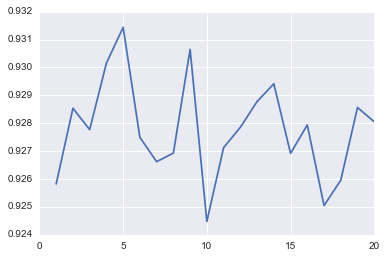

In [232]:
plt.plot(scores[:,:1],scores[:,1:2])

In [233]:
features = [df_train.columns[feat_rank][x] for x in range(5)]
features

['dayofweek', 'holiday', 'dayofyear', 'weekofyear', u'apparenttemperaturemin']

In [235]:
df_train = df[features]
df_train.head()

,dayofweek,holiday,dayofyear,weekofyear,apparenttemperaturemin
time,,,,,
2013-06-30,6,0,181,26,63.23
2013-07-01,0,0,182,27,62.63
2013-07-02,1,0,183,27,61.29
2013-07-03,2,0,184,27,61.29
2013-07-04,3,1,185,27,61.85


In [236]:
X = df_train.values

In [237]:
rf = RandomForestRegressor(100, n_jobs=-1)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [238]:
feat_rank = np.argsort(rf.feature_importances_)[::-1]
feat_rank

array([0, 1, 2, 4, 3])

In [239]:
df_features = pd.DataFrame(rf.feature_importances_,df_train[features].columns, columns = ['feature_value'])
df_features.sort_values('feature_value', ascending=False)

,feature_value
dayofweek,0.748390
holiday,0.092861
dayofyear,0.088339
apparenttemperaturemin,0.048228
weekofyear,0.022183


In [241]:
cross_val_score(rf, X, y, cv=5).mean()

0.94759416680588215

In [215]:
scores = np.zeros((feat_rank.shape[0],2))
for i in range(1,feat_rank.shape[0]+1):
    features = [df_train.columns[feat_rank][x] for x in range(i)]
    scores[i-1:] = (i,(cross_val_score(rf, df_train[features], y, cv=5)).mean())
scores   

array([[  1.        ,   0.73910633],
       [  2.        ,   0.8325523 ],
       [  3.        ,   0.92975035],
       [  4.        ,   0.94628559],
       [  5.        ,   0.94850933],
       [  6.        ,   0.9488245 ],
       [  7.        ,   0.9446933 ],
       [  8.        ,   0.94085495],
       [  9.        ,   0.9406388 ],
       [ 10.        ,   0.9352044 ],
       [ 11.        ,   0.93350304],
       [ 12.        ,   0.93188547],
       [ 13.        ,   0.93074004],
       [ 14.        ,   0.93110188],
       [ 15.        ,   0.93207567],
       [ 16.        ,   0.92997505]])

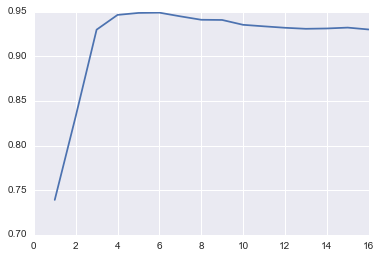

In [216]:
plt.plot(scores[:,:1],scores[:,1:2])

In [161]:
df_cta['predict'] = rf.predict(X)

In [162]:
df_cta['dayofweek'] = pd.DatetimeIndex(df_cta.index).weekday

In [163]:
df_cta

,total_rides,predict,dayofweek
service_date,,,
2011-01-01,582626,708915.32,5
2011-01-02,590051,616703.86,6
2011-01-03,1506805,1486451.78,0
2011-01-04,1567289,1550322.76,1
2011-01-05,1574739,1549488.01,2
2011-01-06,1564764,1555984.21,3
2011-01-07,1549257,1540239.87,4
2011-01-08,874345,882709.09,5
2011-01-09,618123,640566.54,6


### Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                    test_size=0.4, random_state=1)

In [ ]:
rf_train = RandomForestRegressor(40, n_jobs=-1)
rf_train.fit(X_train,y_train)

In [ ]:
rf_train.score(X_test, y_test)

In [ ]:
df_bart['20150101':'20151231'].groupby('dayofweek')[[u'counts', u'counts_normed', u'predict']].mean()

In [ ]:
df_bart['20150101':'20151231'].groupby('dayofweek')['counts_normed'].mean().plot(figsize=(8,5), 
                title='Average percentage of work attendance in 2015', kind='bar', 
                color='lightgray', fontsize = 13)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['mon','tue','wed','thu','fri','sat','sun'])
plt.xlabel='day of the week'
plt.ylabel='percentage'
# 'Average percentage of work attendance in 2015 based on the day of the week. Based on BART exits at Embrcadro, Montgmry, Powell and Civic Ctr from 5a-11a'

## Cross correlation